# Binary Decision Data

This Implementation is done on the two separate files for the isolated cells that Addison has identified as involved in either the first or the second binary decision. Before Actually working with the actual data I want to work with some toy model data so to see if my method works correctly and try to fine tune the paramaters.

In [8]:
import phate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go

# Custom script imports (relative to current working directory)
from Python_Scripts.Data_Selection import *
from Python_Scripts.Data_Selection_for_BD import *


# Load data

In [9]:
# Load CSV files into a DataFrame
file1 = '/Users/amittaris/Documents/GitHub/Dimensionality-Reduction-for-Cellular-Differentiation-/DR notebooks/PHATE/datasets/df_facs_decision1.csv'
df_facs_decision1 = pd.read_csv(file1)

file2 ='/Users/amittaris/Documents/GitHub/Dimensionality-Reduction-for-Cellular-Differentiation-/DR notebooks/PHATE/datasets/df_facs_decision2.csv'
df_facs_decision2 = pd.read_csv(file2)


# Subset data by qual amounts for each timepoint 

In [10]:
selected_data_1, combined_equal_data_1  = data_selector_for_bd(7200, df_facs_decision1)
selected_data_2, combined_equal_data_2  = data_selector_for_bd(7200, df_facs_decision2)

# Define PHATE parameters

In [11]:
#I am doing an embedding on only the first decision but it may be more useful to consider the whole framework firstly and then color the binary decisions 
phate_op = phate.PHATE(
    random_state=42,
    knn=10,           # slightly larger neighborhood to stabilize the graph
    decay=30,         # good balance of locality
    t='auto',    # high diffusion time for smooth trajectories
)


# PHATE graphed by regions where each gene is mostly expressed

In [12]:

BD_embedding_1 = phate_op.fit_transform(selected_data_1)

Calculating PHATE...
  Running PHATE on 50400 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 4.82 seconds.
    Calculating affinities...
    Calculated affinities in 0.24 seconds.
  Calculated graph and diffusion operator in 5.12 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.11 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.66 seconds.
  Calculated landmark operator in 9.66 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 5.24 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.91 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.67 seconds.
Calculated PHATE in 23.62 seconds.


In [30]:
import matplotlib.pyplot as plt

def plot_phate_multi_gene_grid(embedding, gene_list, expression_data, cmap='viridis'):
    n = len(gene_list)
    ncols = 3
    nrows = -(-n // ncols)  # Ceiling division for rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()

    for i, gene in enumerate(gene_list):
        ax = axes[i]
        gene_expression = expression_data[gene].values

        sc = ax.scatter(
            embedding[:, 0], embedding[:, 1],
            c=gene_expression, cmap=cmap, s=10, alpha=0.8
        )
        ax.set_title(f'{gene} Expression')
        ax.set_xlabel('PHATE 1')
        ax.set_ylabel('PHATE 2')
        plt.colorbar(sc, ax=ax, label=gene)

    # Turn off unused axes if any
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


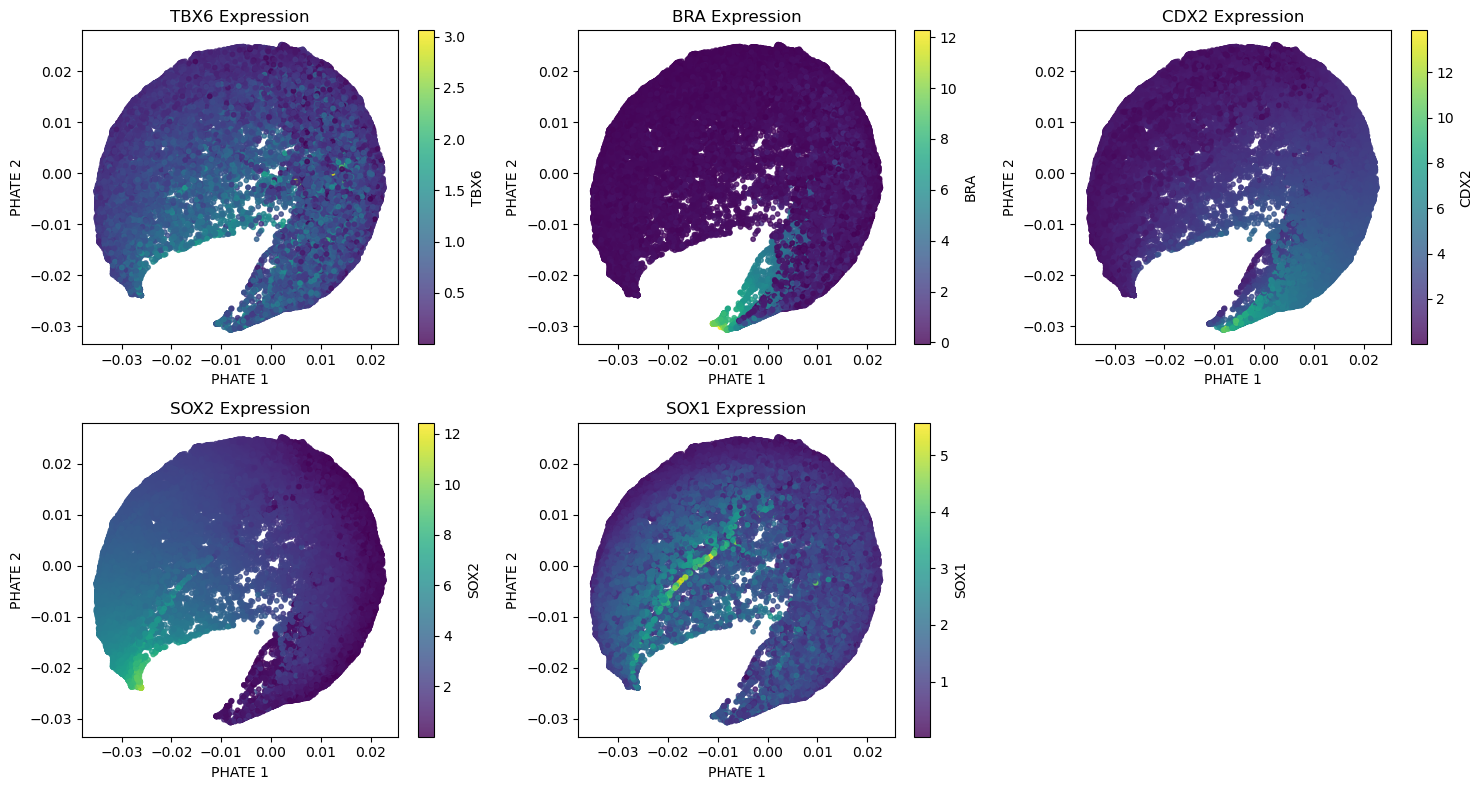

In [14]:
genes = ['TBX6', 'BRA', 'CDX2', 'SOX2', 'SOX1']
plot_phate_multi_gene_grid(BD_embedding_1, genes, combined_equal_data_1)


# Try to separate cells by setting boundaries for each gene expression

In [15]:
# Rough thresholds (adjust to your data scale)
sox2_thresh = combined_equal_data_1['SOX2'].quantile(0.6)  # Top 25% = "++"
sox1_thresh  =  combined_equal_data_1['SOX1'].quantile(0.5)
sox1_thresh_2  =  combined_equal_data_1['SOX1'].quantile(0.2)
cdx2_thresh = combined_equal_data_1['CDX2'].quantile(0.5)   # Median = "+"
bra_thresh =  combined_equal_data_1['BRA'].quantile(0.1) 

def classify_cell(row):
    if row['SOX2'] > sox2_thresh and row['SOX1'] < sox1_thresh_2:
        return 'EPI'
    elif row['SOX1'] > sox1_thresh and row['SOX2'] >  sox2_thresh:
        return 'AN'
    elif row['CDX2'] > 0.5 and row['BRA'] >bra_thresh:
        return 'CE'
    else:
        return 'Unclassified'


In [16]:
# Apply classification
cell_labels = combined_equal_data_1.apply(classify_cell, axis=1)

# Optional: map to colors
label_colors = {'EPI': 'blue', 'AN': 'green', 'CE': 'red', 'Unclassified': 'gray'}
colors_mapped = cell_labels.map(label_colors)


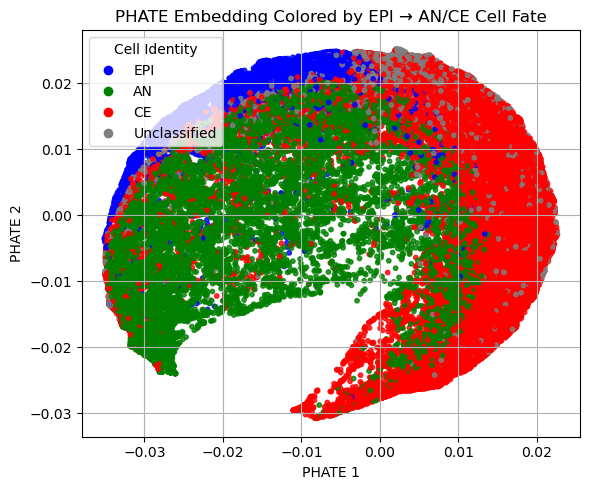

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(
    BD_embedding_1[:, 0], BD_embedding_1[:, 1],
    c=colors_mapped,
    s=10, alpha=0.8
)

plt.title("PHATE Embedding Colored by EPI → AN/CE Cell Fate")
plt.xlabel("PHATE 1")
plt.ylabel("PHATE 2")

# Create legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=key,
           markerfacecolor=color, markersize=8)
    for key, color in label_colors.items()
]
plt.legend(handles=legend_elements, title="Cell Identity")
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot PHATE marking the cluster_post_replacement identified cells

In [18]:
#I am doing an embedding on only the first decision but it may be more useful to consider the whole framework firstly and then color the binary decisions 
phate_op1 = phate.PHATE(
    random_state=1,
    knn=10,           # slightly larger neighborhood to stabilize the graph
    decay=30,         # good balance of locality
    t='auto',    # high diffusion time for smooth trajectories
)


# Decision 1

In [ ]:
# Forcefully define valid timepoints
genes = df_facs_decision1.drop(df_facs_decision1.columns[[0,1,7,9,10]], axis=1) 


valid_timepoints_for_1 = [2.0, 2.5, 3.0, 3.5]
filtered_df = genes[genes['timepoint'].isin(valid_timepoints_for_1)]

cell_types_0 = filtered_df[filtered_df['cluster_post_replacement'].isin([0])]
cell_types_1 = filtered_df[filtered_df['cluster_post_replacement'].isin([1])]
cell_types_2 = filtered_df[filtered_df['cluster_post_replacement'].isin([2])]
cell_types_3 = filtered_df[filtered_df['cluster_post_replacement'].isin([3])]

phate_data = filtered_df.drop(filtered_df.columns[[5, 6, 7]], axis=1)

reduced_data = phate_op1.fit_transform(phate_data)



Calculating PHATE...
  Running PHATE on 86400 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 9.37 seconds.
    Calculating affinities...
    Calculated affinities in 0.34 seconds.
  Calculated graph and diffusion operator in 9.77 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 7.72 seconds.
    Calculating KMeans...
    Calculated KMeans in 7.31 seconds.
  Calculated landmark operator in 16.41 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 8.06 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.76 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.83 seconds.
Calculated PHATE in 39.88 seconds.


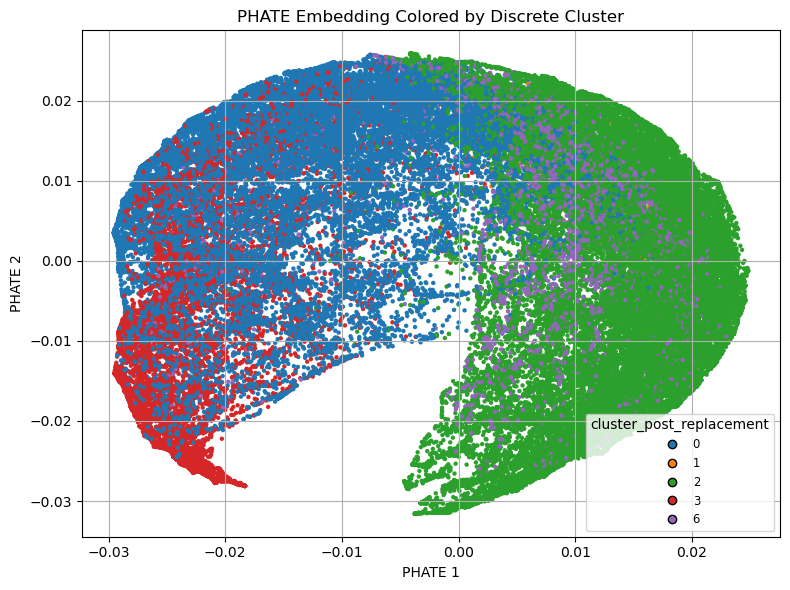

In [20]:
# 1. Extract cluster labels
clusters = filtered_df['cluster_post_replacement'].values
unique_clusters = sorted(np.unique(clusters))  # Ensure consistent ordering

# 2. Map each cluster to an index
cluster_to_code = {cluster: i for i, cluster in enumerate(unique_clusters)}
color_codes = np.array([cluster_to_code[c] for c in clusters])

# 3. Define a custom color palette
custom_cmap = ListedColormap([
    "#1f77b4",  # dark blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # yellow-green
    "#17becf"   # cyan
][:len(unique_clusters)])  # truncate if fewer than 10 clusters

# 4. Plot PHATE embedding with discrete colors
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_data[:, 0], reduced_data[:, 1],
    c=color_codes,
    cmap=custom_cmap,
    s=10,
    alpha=1.0,
    edgecolors='none'
)

# 5. Custom legend (color matched to cluster label)
handles = [
    plt.Line2D([], [], marker='o', linestyle='',
               label=str(cluster),
               markerfacecolor=custom_cmap(code),
               markeredgecolor='k',
               markersize=6)
    for cluster, code in cluster_to_code.items()
]

plt.legend(handles=handles, title='cluster_post_replacement', loc='best', fontsize='small')
plt.title('PHATE Embedding Colored by Discrete Cluster')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.grid(True)
plt.tight_layout()
plt.show()


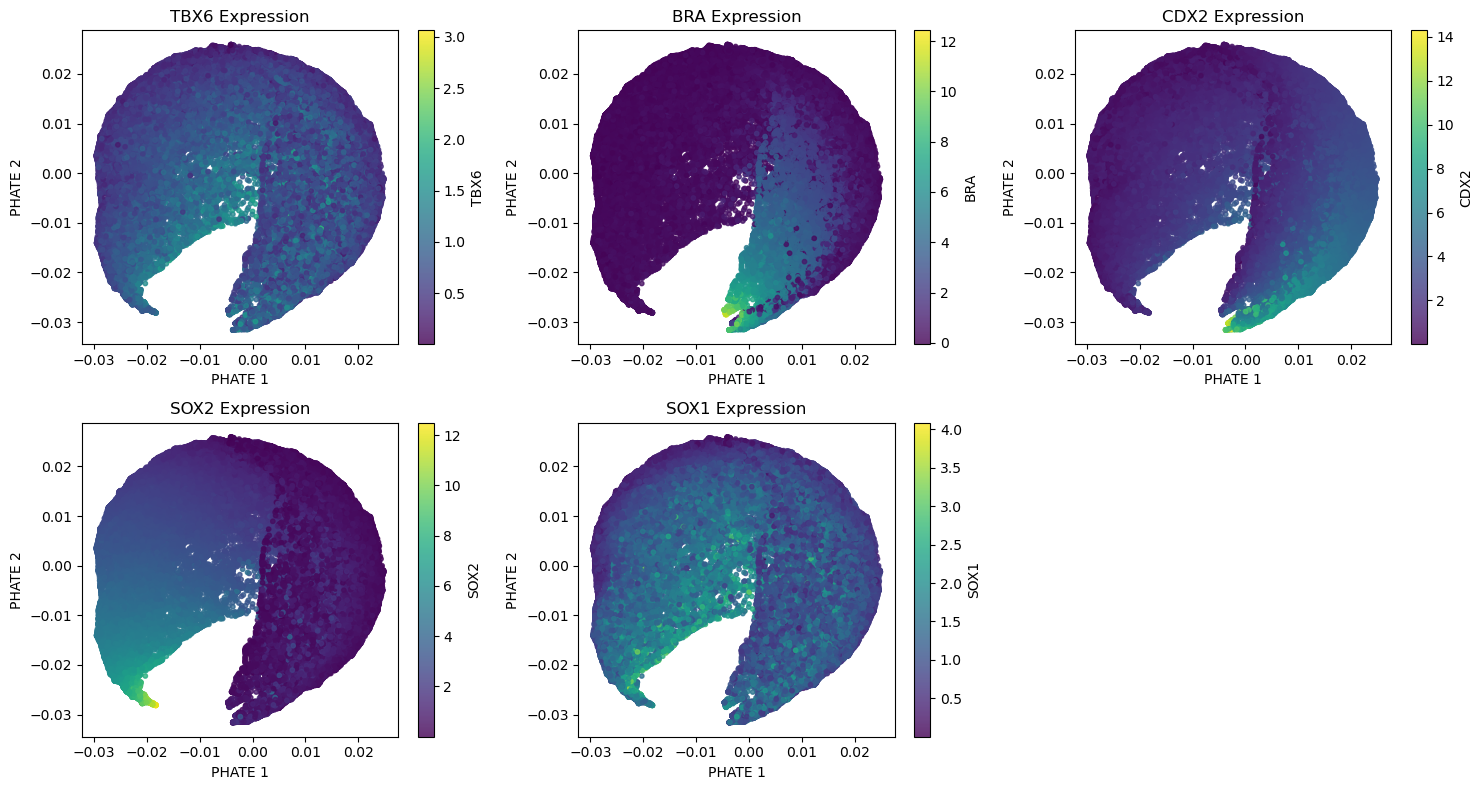

In [34]:
genes = ['TBX6', 'BRA', 'CDX2', 'SOX2', 'SOX1']
plot_phate_multi_gene_grid(reduced_data, genes, filtered_df)

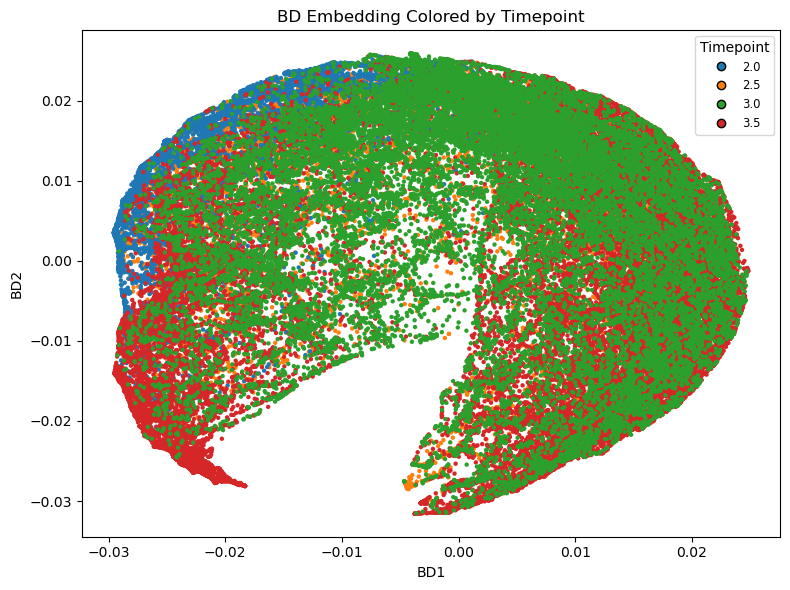

In [129]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Define valid timepoints
valid_timepoints = [2.0, 2.5, 3.0, 3.5]

# Map timepoints to codes
labels = filtered_df['timepoint'].values
timepoint_to_code = {tp: i for i, tp in enumerate(valid_timepoints)}
color_codes = np.array([timepoint_to_code[tp] for tp in labels])

# Confirm color codes are within expected range
assert np.all((color_codes >= 0) & (color_codes < len(valid_timepoints))), "Color code out of bounds"

# Define a custom colormap of the correct length (4 colors)
custom_cmap = ListedColormap([
    "#1f77b4",  # dark blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
])

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_data[:, 0],  reduced_data[:, 1],
    c=color_codes,
    cmap=custom_cmap,
    s=10,
    alpha=1.0,
    edgecolors='none'
)

# Add legend
handles = [
    plt.Line2D([], [], marker='o', linestyle='',
               label=str(tp),
               markerfacecolor=custom_cmap(code),
               markeredgecolor='k',
               markersize=6)
    for tp, code in timepoint_to_code.items()
]

plt.legend(handles=handles, title='Timepoint', loc='best', fontsize='small')
plt.xlabel('BD1')
plt.ylabel('BD2')
plt.title('BD Embedding Colored by Timepoint')
plt.tight_layout()
plt.show()


# Decision 2

In [23]:
# Forcefully define valid timepoints
genes_2 = df_facs_decision2.drop(df_facs_decision2.columns[[0,1,7,9,10]], axis=1) 

valid_timepoints_for_2 = [3.0, 3.5, 4.0, 4.5, 5.0]
filtered_df_2 = genes_2[genes_2['timepoint'].isin(valid_timepoints_for_2)]

cell_types_3 = filtered_df[filtered_df['cluster_post_replacement'].isin([3])]
cell_types_4 = filtered_df[filtered_df['cluster_post_replacement'].isin([4])]
cell_types_5 = filtered_df[filtered_df['cluster_post_replacement'].isin([5])]

phate_data_2 = filtered_df_2.drop(filtered_df_2.columns[[5, 6]], axis=1)

reduced_data_2 = phate_op1.fit_transform(phate_data_2)


Calculating PHATE...
  Running PHATE on 217997 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 60.32 seconds.
    Calculating affinities...
    Calculated affinities in 0.96 seconds.
  Calculated graph and diffusion operator in 61.42 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 20.72 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.96 seconds.
  Calculated landmark operator in 29.53 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 3.70 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.85 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.46 seconds.
Calculated PHATE in 97.99 seconds.


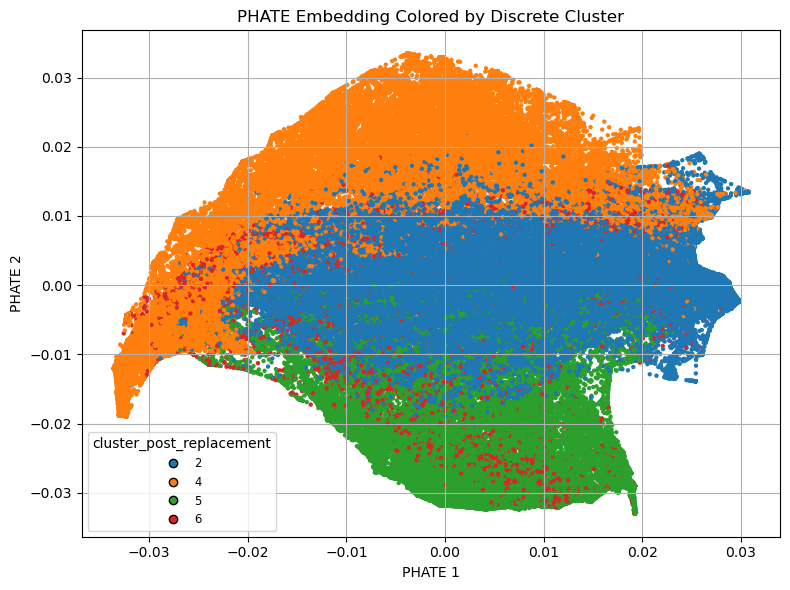

In [24]:
# 1. Extract cluster labels
clusters = filtered_df_2['cluster_post_replacement'].values
unique_clusters = sorted(np.unique(clusters))  # Ensure consistent ordering

# 2. Map each cluster to an index
cluster_to_code = {cluster: i for i, cluster in enumerate(unique_clusters)}
color_codes = np.array([cluster_to_code[c] for c in clusters])

# 3. Define a custom color palette
custom_cmap = ListedColormap([
    "#1f77b4",  # dark blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # yellow-green
    "#17becf"   # cyan
][:len(unique_clusters)])  # truncate if fewer than 10 clusters

# 4. Plot PHATE embedding with discrete colors
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_data_2[:, 0], reduced_data_2[:, 1],
    c=color_codes,
    cmap=custom_cmap,
    s=10,
    alpha=1.0,
    edgecolors='none'
)

# 5. Custom legend (color matched to cluster label)
handles = [
    plt.Line2D([], [], marker='o', linestyle='',
               label=str(cluster),
               markerfacecolor=custom_cmap(code),
               markeredgecolor='k',
               markersize=6)
    for cluster, code in cluster_to_code.items()
]

plt.legend(handles=handles, title='cluster_post_replacement', loc='best', fontsize='small')
plt.title('PHATE Embedding Colored by Discrete Cluster')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.grid(True)
plt.tight_layout()
plt.show()


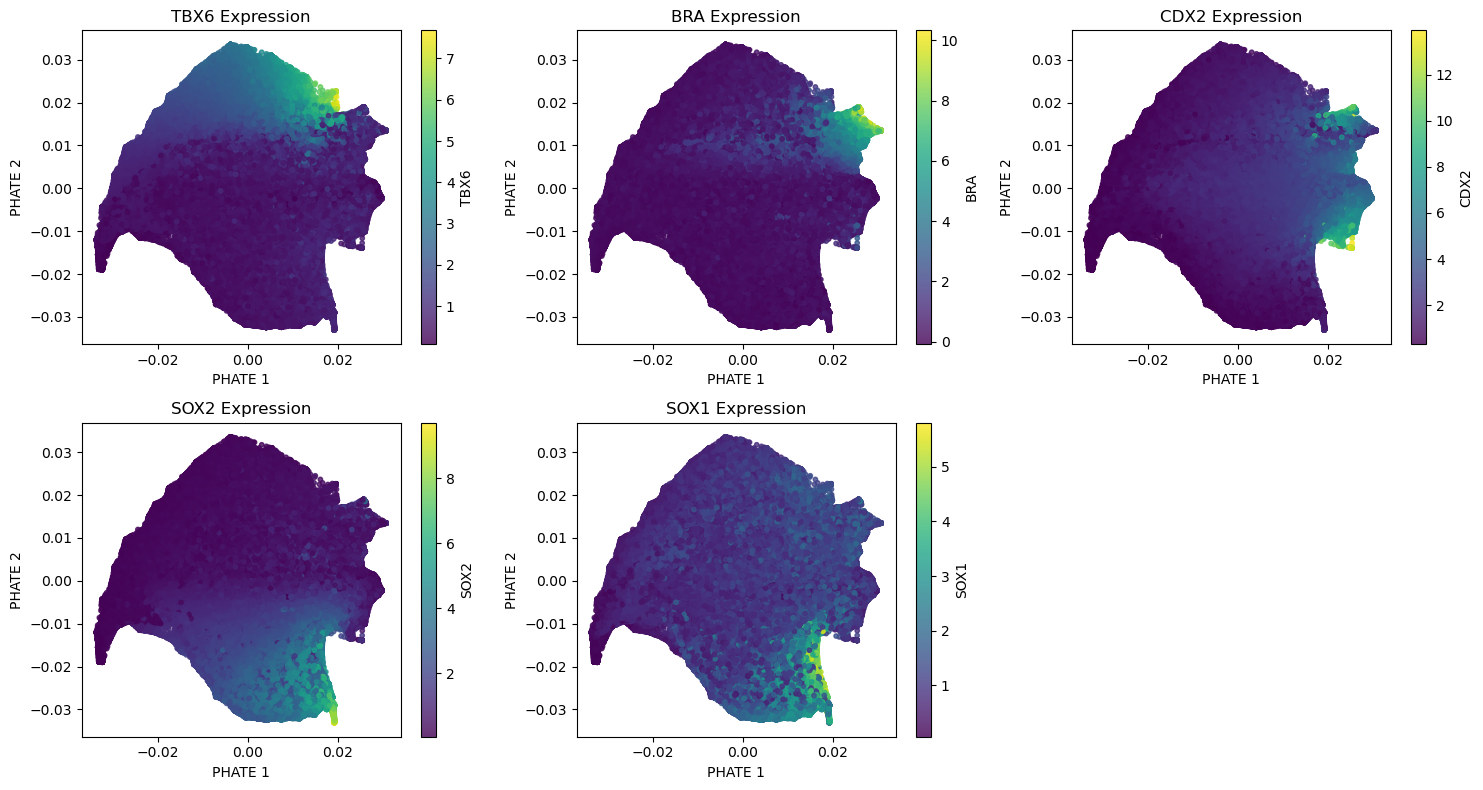

In [32]:
genes = ['TBX6', 'BRA', 'CDX2', 'SOX2', 'SOX1']
plot_phate_multi_gene_grid(reduced_data_2, genes, filtered_df_2)

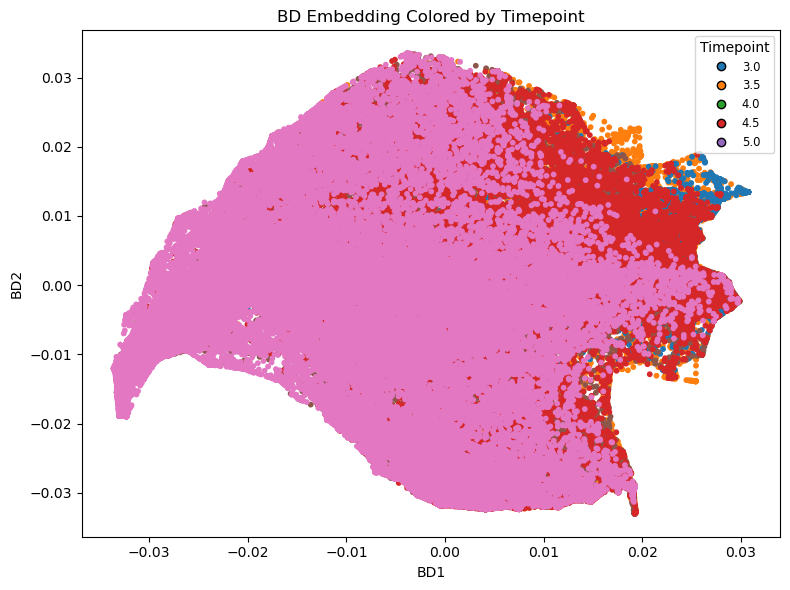

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Forcefully define valid timepoints
valid_timepoints = [3.0, 3.5, 4.0, 4.5, 5.0]

labels = filtered_df_2['timepoint'].values
timepoint_to_code = {tp: i for i, tp in enumerate(valid_timepoints)}
color_codes = np.array([timepoint_to_code[tp] for tp in labels])

# Confirm all values are in 0–6
assert np.all((color_codes >= 0) & (color_codes < 7)), "Color code out of bounds"

# Set a custom, locked 7-color palette
custom_cmap = ListedColormap([
    "#1f77b4",  # dark blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
])

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_data_2 [:, 0], reduced_data_2 [:, 1],
    c=color_codes,
    cmap=custom_cmap,
    s=10,
    alpha=1.0
)

# Legend
handles = []
for tp, code in timepoint_to_code.items():
    handles.append(plt.Line2D([], [], marker='o', linestyle='',
                              label=str(tp),
                              markerfacecolor=custom_cmap(code),
                              markeredgecolor='k',
                              markersize=6))

plt.legend(handles=handles, title='Timepoint', loc='best', fontsize='small')
plt.xlabel('BD1')
plt.ylabel('BD2')
plt.title('BD Embedding Colored by Timepoint')
plt.tight_layout()
plt.show()

